In [1]:
# Set working directory (optional during development)
import os
os.chdir('/Users/sudishmakarki/My_project2')  # only if needed
print(" Working directory:", os.getcwd())

# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics
import scipy.stats as stats


# Custom Functions
from models.data_interpolation import (
    load_data,
    preprocess_data,
    split_train_test,
    generate_time_series_splits
)

from models.model_sarimax import (
    prepare_sarimax_data,
    check_stationarity,
    plot_acf_pacf,
    fit_sarimax_model,
    analyze_residual_spike,
    ljung_box_test,
    forecast_sarimax_model,
    identify_peak_hours_sarimax,
    evaluate_sarimax_metrics,
    rolling_forecast_sarimax,
    generate_future_forecast_sarimax,
    group_forecast_by_hour,
    
)

from models.model_sarimax import (
    sarimax_grid_search,
    retrain_sarimax_model,
    ljung_box_test_residuals,
    forecast_with_refined_sarimax,
    analyze_peak_hours_sarimax_refined,
    evaluate_refined_sarimax_metrics,
    rolling_forecast_sarimax_refined,
    forecast_future_sarimax_model_refined,
    future_forecast_by_hour_sarimax_refined
)

 Working directory: /Users/sudishmakarki/My_project2


In [2]:
# Load and preprocess
df = load_data('data/RestaurantData.csv')
df_clean = preprocess_data(df)

                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

In [3]:
# Split into train and test
restaurant_train, restaurant_test = split_train_test(df_clean, split_date='2022-01-01')
# Format for SARIMAX
train_series, test_series = prepare_sarimax_data(restaurant_train, restaurant_test)

Baseline Model for SARIMAX

ADF Statistic: -15.026219911968534
p-value: 1.00551216199881e-27
Result: Stationary


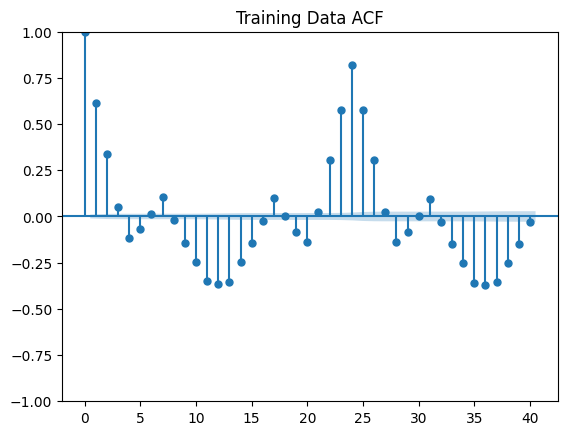

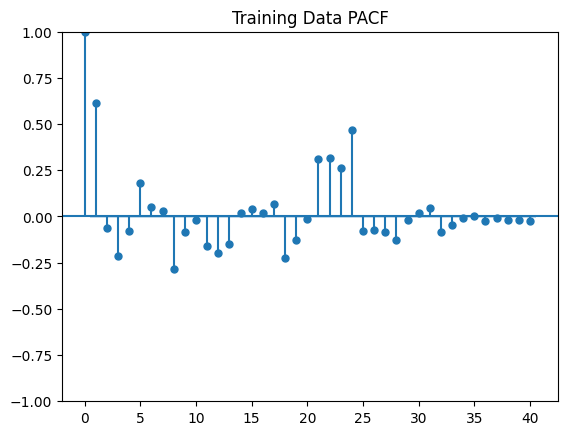

In [4]:
# --- Stationarity Check & ACF/PACF ---
check_stationarity(train_series)
plot_acf_pacf(train_series, lags=40, title_prefix="Training Data")

In [ ]:
# --- Fit SARIMAX Baseline Model ---
results_sarimax = fit_sarimax_model(train_series)

In [ ]:
# -- Residual Analysis ---
residuals = results_sarimax.resid

# Residual plot + ACF/PACF
plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()

In [ ]:
plot_acf_pacf(residuals, lags=40, title_prefix="SARIMAX Residuals")

In [ ]:
# Residual spike + Ljung-Box
analyze_residual_spike(residuals, train_series.to_frame(name="CustomerCount/n"))
ljung_box_test(residuals)

In [ ]:
# --- Forecast on Test Set ---
forecast_mean, forecast_ci = forecast_sarimax_model(results_sarimax, len(test_series), test_index=test_series.index)
forecast_mean.head()
forecast_ci.head()

# --- Overall Forecast vs Actual --
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Overall)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.show()

In [ ]:
# --- Zoomed-In View: First Month of 2022 ---
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Zoomed-In: January 2022)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-02-01"))
plt.legend()
plt.show()

In [ ]:
# --- Zoomed-In View: First Week of January 2022 ---
plt.figure(figsize=(10, 5))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Zoomed-In: First Week of January 2022)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.xlim(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-01-08"))
plt.legend()
plt.show()

In [ ]:
# ---Peak Hour Detection ---
peak_hours, threshold, hourly_avg, forecast_peak, test_peak = identify_peak_hours_sarimax(forecast_mean, test_series)

# Display threshold and peak hours
print(f" Threshold for Peak Hours: {threshold:.2f}")
print(f" Dynamically Identified Peak Hours: {peak_hours}")

# Convert hourly average to a tidy DataFrame
hourly_avg_df = hourly_avg.reset_index()
hourly_avg_df.columns = ['Hour of Day', 'Average Forecasted Customers']
hourly_avg_df['Average Forecasted Customers'] = hourly_avg_df['Average Forecasted Customers'].round(2)

# View hourly average
# Heatmap-style table for hourly averages
display(
    hourly_avg_df
    .style
    .hide(axis="index")  # hide the default index column
    .set_caption("Hourly Average Forecast - SARIMAX")
    .background_gradient(cmap='YlOrRd')  # warm colors for peak intensity
)

# Show preview of peak hour filtered data
print("\nForecasted Data (Peak Hours):")
display(forecast_peak.head())

print("\nActual Data (Peak Hours):")
display(test_peak.head())

In [ ]:
# Plot forecast vs actual for peak hours
plt.figure(figsize=(10, 5))
plt.scatter(test_peak.index, test_peak['y'], color='red', label='Actual Peak Hours', alpha=0.7)
plt.plot(forecast_peak.index, forecast_peak['yhat'], marker='o', linestyle='-', color='blue', label='SARIMAX Forecast (Peak Hours)')
plt.title("SARIMAX Forecast vs Actual for Dynamically Identified Peak Hours")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# --- 7. Evaluate Metrics (Overall & Peak) ---
metrics = evaluate_sarimax_metrics(test_series, forecast_mean, test_peak, forecast_peak)

# Format metrics into a list of rows
metrics_table = [
    ["MAE", "Overall", metrics["overall"]["MAE"]],
    ["RMSE", "Overall", metrics["overall"]["RMSE"]],
    ["MAPE", "Overall", metrics["overall"]["MAPE"]],
    ["MAE", "Peak Hours", metrics["peak_hours metrics"]["MAE"]],
    ["RMSE", "Peak Hours", metrics["peak_hours metrics"]["RMSE"]],
    ["MAPE", "Peak Hours", metrics["peak_hours metrics"]["MAPE"]],
]

# Convert to DataFrame
baseline_metrics_df = pd.DataFrame(metrics_table, columns=["Metric", "Type", "Value"])

# Create the styled DataFrame
styled_df = (
    baseline_metrics_df
    .style
    .set_caption("SARIMAX Baseline: Forecast Evaluation Metrics")
    .format({"Value": "{:.2f}"})
    .background_gradient(cmap="Blues", subset=["Value"])
)

# Display without index by resetting index and dropping it
display(
    styled_df.hide(axis='index')  # works in pandas >= 1.3.0
)

In [ ]:
# --- Rolling Forecast Evaluation ---
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 24)

rolling_overall, rolling_peak, *_ = rolling_forecast_sarimax(
    train_series,
    test_series,
    order=order,
    seasonal_order=seasonal_order,
    peak_hours_dynamic=peak_hours,
    window_size=500,
    step=5,
    forecast_steps=1,
    max_points=50
)

print("\nRolling Forecast (Overall):", rolling_overall)
print("\nRolling Forecast (Peak Hours):", rolling_peak)

In [ ]:
# Generate 30-day ahead forecast using SARIMAX
forecast_future_sarimax = generate_future_forecast_sarimax(results_sarimax, periods=30*24)

# Preview the forecast
forecast_future_sarimax.head()

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(forecast_future_sarimax['ds'], forecast_future_sarimax['yhat'], color='blue', label='Forecasted Customer Count')
plt.title("SARIMAX: Future Forecast (Next 30 Days - Hourly)")
plt.xlabel("Date")
plt.ylabel("Forecasted Customer Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Group future forecast by hour and find peak hours
hourly_avg_sarimax, threshold_sarimax, future_peak_hours_sarimax = group_forecast_by_hour(
    forecast_future_sarimax, threshold_ratio=0.6
)

# Display the colored hourly forecast table
display(
    hourly_avg_sarimax
    .style
    .set_caption("SARIMAX: 30-Day Future Hourly Avg Forecast")
    .background_gradient(cmap='Blues', axis=0)
    .hide(axis="index")  # Optional: hide index for clean look
)

# Print peak hour info
print(f"\nThreshold for Peak Hours (60% of max): {threshold_sarimax:.2f}")
print(f"Future Peak Hours Identified: {future_peak_hours_sarimax}")

SARIMAX Grid search for model refinement 

In [ ]:
# --- Grid Search for Best SARIMAX Parameters ---
results_df, best_params = sarimax_grid_search(train_series)

In [ ]:
# --- Retrain the SARIMAX Model ---
best_order = best_params['order']
best_seasonal_order = best_params['seasonal_order']
results_sarimax_best = retrain_sarimax_model(train_series, best_order, best_seasonal_order)


In [ ]:
# --- Residual Diagnostics ---
residuals_refined = results_sarimax_best.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals_refined)
plt.title("Residuals Over Time (Refined SARIMAX Model)")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(residuals_refined.dropna(), kde=True, color='blue')
plt.title("Histogram of Residuals (Refined SARIMAX Model)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals_refined.dropna(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Refined SARIMAX Model)")
plt.tight_layout()
plt.show()


In [ ]:
# --- Ljung-Box Test ---
ljung_box_test_residuals(residuals_refined)

In [ ]:
# --- Step 7: Forecast on Test Set ---
forecast_mean, forecast_ci = forecast_with_refined_sarimax(results_sarimax_best, test_series)

plt.figure(figsize=(12, 6))
plt.plot(train_series.index, train_series, label='Training Data', color='steelblue')
plt.plot(test_series.index, test_series, label='Actual Test Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMAX Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title("SARIMAX Forecast vs Actual (Refined Model)")
plt.xlabel("Time")
plt.ylabel("CustomerCount")
plt.legend()
plt.show()


In [ ]:
# --- Step 8: Peak Hour Analysis ---
peak_hours_sr1, threshold, hourly_avg, forecast_peak, test_peak = analyze_peak_hours_sarimax_refined(forecast_mean, test_series)

# Display hourly average forecast nicely
display(hourly_avg.reset_index(name='Avg Forecast (yhat)').style.set_caption("Refined SARIMAX: Hourly Avg Forecast").background_gradient(cmap='YlOrRd'))  # warm colors for peak intensity

print("\nThreshold for Peak Hours:", threshold)
print("\nDynamically Identified Peak Hours:", peak_hours_sr1)

In [ ]:
# --- Step 9: Error Metrics ---
metrics_table = evaluate_refined_sarimax_metrics(test_series, forecast_mean, test_peak, forecast_peak)
refined_metrics_df = pd.DataFrame(metrics_table, columns=['Metric', 'Type', 'Value'])
display(refined_metrics_df.style.set_caption("Refined SARIMAX: Forecast Evaluation Metrics").background_gradient(cmap='Blues', subset=['Value']))


In [ ]:
# --- 30-Day Future Forecast ---
forecast_future_sarimax = forecast_future_sarimax_model_refined(results_sarimax_best)
forecast_future_sarimax.head()

In [ ]:
# --- Step 11: Future Forecast by Hour ---
future_hourly_avg_df_sr1, future_threshold_sr1, future_peak_hours_sr1 = future_forecast_by_hour_sarimax_refined(forecast_future_sarimax)

# Display heatmap style
display(future_hourly_avg_df_sr1.style.set_caption(" Refined SARIMAX: Future Avg Forecast by Hour").background_gradient(cmap='Blues', axis=0))
print("\nThreshold for Future Peak Hours:", future_threshold_sr1)
print("\nDynamically Selected Future Peak Hours:", future_peak_hours_sr1)

In [ ]:
# --- Step 12: Plot Future Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_future_sarimax['ds'], forecast_future_sarimax['yhat'], color='blue', label='Forecasted Customer Count')
plt.title("Refined SARIMAX: Future Forecast (Next 30 Days - Hourly)")
plt.xlabel("Date")
plt.ylabel("Forecasted Customer Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


SARIMAX Exogenous Variables model refinement 